Fig7d, currents during action potential in the axon

In [1]:
from neuron import h
import numpy as np
import os.path
import sys
sys.path.append('../../libs/')

In [2]:
# load model
# works only on linux
model = '../../data/morphology/soma_axon.hoc'
dllpath = '../../data/morphology/x86_64/.libs/libnrnmech.so'
h.nrn_load_dll(dllpath)
h.load_file(model)
h.init_cell()

0.0

In [3]:
# parameters
keep_soma_Na = True
soma_size = 1 # 1, 30, 50 um
stim_amp = 0.0037
# use different amplitude for stimulation depending on the soma size size:amplitude 
# (1:0.0037,30:0.033,50:0.4)

# simulation
h.tstart = 0.
h.tstop = 20.
h.dt = 0.001
rm = 30000.
st_dur1 = 2.
st_dur2 = 3.
v_init = -70

# morphology 
h.soma.L = soma_size
h.soma.diam = soma_size
h.soma.nseg = 6
h.soma.g_pas = 1./rm
h.soma.cm = 0.75

h.axon.L = 50.
h.axon.diam =1.
h.axon.nseg = 10
h.axon.g_pas = 1./rm
h.axon.cm = 0.75 * 0.75

# general
h.rm = rm
h.v_init = v_init
h.ra = 150 
h.c_m = 0.75
h.xn = 1 

# potassium
h.Ek = -80. # mV # Fig2: = 80; Fig4b:
h.gk = 1600.
h.gkm = 0.3
h.soma.gbar_kv = 1600/5.
h.axon.gbar_kv = 1600.

# sodium
h.Ena = 60.
h.gna = 8000.
h.gkm_soma = 0.3
if keep_soma_Na:
    h.soma.gbar_na = 0.1*8000
else:
    h.soma.gbar_na = 0.
h.axon.gbar_na = 8000.
            
# calcium (set no calcium in the model)
h.gca = 0.
h.gkca = 0.
h.gca_soma = 0.
h.gkca_soma = 0.

In [4]:
# create I-clamp stimulation
st = h.IClamp(0.5, sec = h.soma)
st.dur = 7 # ms
st.delay = 1
st.amp = stim_amp

In [5]:
# record currents throughout the axon
k_current_axon = []
na_current_axon = []
area_axon_segs = []
# create vectors for recording currents from the axon
for idx in range(h.axon.nseg): #seg in eval(axon_name_sec + '.allseg()'):
    next_seg = 0.+(1./h.axon.nseg/2.)+idx*2*(1./h.axon.nseg/2.)
    # Na and K
    k_current_axon.append(h.Vector())
    k_current_axon[-1].record(h.axon(next_seg)._ref_ik, sec=h.axon)
    na_current_axon.append(h.Vector())
    na_current_axon[-1].record(h.axon(next_seg)._ref_ina, sec=h.axon)
    
    area_axon_segs.append(h.axon(next_seg).area())

end_axon_v = h.Vector()
end_axon_v.record(h.axon(next_seg)._ref_v, sec=h.axon)

# create vectors for recording capacitive current
vec_axon_start = h.Vector()
vec_axon_start.record(h.axon(0.01)._ref_v, sec=h.axon)

vec_soma_end = h.Vector()
vec_soma_end.record(h.soma(0.99)._ref_v, sec=h.soma)

h.run()

0.0

In [6]:
k_current_axon_all = 0
na_current_axon_all = 0
assert len(k_current_axon) == len(na_current_axon)
for idx in range(len(k_current_axon)):
    k_current_axon_all += np.array(k_current_axon[idx])*area_axon_segs[idx]* 1e-2
    na_current_axon_all += np.array(na_current_axon[idx])*area_axon_segs[idx]* 1e-2

end_axon_v = np.array(end_axon_v)
v_soma_end = np.array(vec_soma_end)
v_axon_start = np.array(vec_axon_start)
ri_axonstart = h.axon(0.01).ri()
axial_i = (v_axon_start-v_soma_end)/ri_axonstart

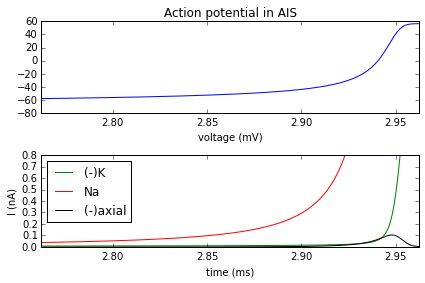

In [8]:
# plot the figure
import matplotlib.pylab as plt
%matplotlib inline
limit = np.argmax(end_axon_v)

plt.subplot(2,1,1)
plt.title('Action potential in AIS')
time = np.arange(len(end_axon_v))*h.dt
limit = time[limit]
plt.plot(time, end_axon_v, 'b', label = 'spike')
plt.xlim([limit-0.2,limit])
plt.xlabel('voltage (mV)')

plt.subplot(2,1,2)
plt.plot(time, k_current_axon_all, 'g', label = '(-)K')
plt.plot(time, na_current_axon_all*(-1), 'r', label = 'Na')
plt.plot(time, axial_i, 'k', label = '(-)axial')

plt.legend(loc=2)
plt.xlabel('time (ms)')
plt.ylabel('I (nA)')
plt.xlim([limit-0.2,limit])
plt.ylim([0,0.8])

plt.tight_layout()